{'100': 6, '101': 8, '010': 12, '000': 13, '110': 21, '011': 4, '111': 500, '001': 460}


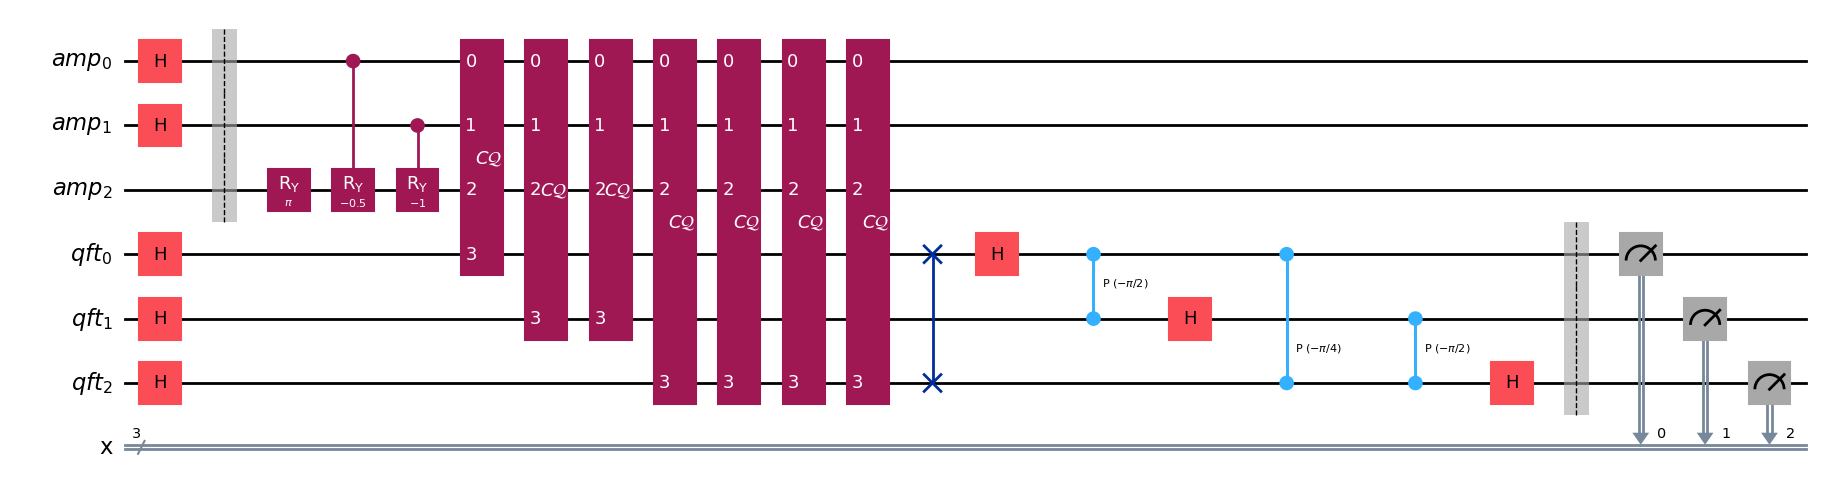

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Qiskitから必要なモジュールをインポート
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.library import MCXGate  # MCXGateをインポート
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram

# 量子数値積分（Quantum Numerical Integration）とは、
# 量子コンピュータを用いて数値積分を効率的に行う手法のことです。
# これは、特に古典的な数値計算では計算コストが高くなるような高次元積分に対して、
# 量子アルゴリズムによって計算時間の短縮を目指す分野です。
# 特に有名なのが 量子モンテカルロ積分（Quantum Monte Carlo Integration） や 
# 量子振幅推定（Quantum Amplitude Estimation） に基づくアプローチです。

# 以下のコードは、量子振幅推定に基づいた量子数値積分（Quantum Numerical Integration）の一例として構成されています。
# 大まかな流れとしては、
# 初期状態の準備、
# 関数（あるいは評価したい積分対象）の振幅エンコード、
# 制御付きの演算子（ここでは 𝑄 と表記）の複数回適用、
# そして**逆量子フーリエ変換（inverse QFT）**によって位相（＝積分値に対応するパラメータ）を読み出すという、
# 量子振幅推定アルゴリズムの骨格を示しています。



# 1.回路の構成とレジスタの設定
## 量子レジスタの定義
qr_amp = QuantumRegister(3, name='amp') # qr_amp（3量子ビット）：振幅エンコードや振幅増幅（amplitude amplification）に用いるレジスタ。
qr_qft = QuantumRegister(3, name='qft') # qr_qft（3量子ビット）：後半の逆量子フーリエ変換（inverse QFT）で位相推定するためのレジスタ。
c = ClassicalRegister(3, name='x') # （古典レジスタ、3ビット）：測定結果の記録に使用します。

circuit = QuantumCircuit(qr_amp, qr_qft, c) # 回路の作成


## 初期状態Pの準備
circuit.h([0, 1, 3, 4, 5])
# 回路の最初で circuit.h([0, 1, 3, 4, 5]) として、qr_amp の一部（0,1）と qr_qft の全ビットにアダマール変換を適用しています。
# なお、qr_amp の2番目（グローバルなインデックスでは2番目）はその後に別途操作されます。

circuit.barrier(qr_amp)



# 2. 関数エンコードと状態準備
## R部 (Rotation) の実装 （ a=sin^2(θ) ）
circuit.ry(np.pi, 2)
circuit.cry(-1 / 2, qr_amp[0], qr_amp[2])
circuit.cry(-1, qr_amp[1], qr_amp[2])
# ここでは、qr_amp[2] に対して単独および制御付きの RY 回転を行い、
# 積分対象となる関数の情報（あるいは重み付け）をエンコードする処理を行っていると考えられます。
# ※ここで使われる角度（例えば -1/2 や -1 など）は、振幅増幅アルゴリズムにおける位相情報のエンコードに対応しているとみなせます。

# 量子振幅推定の基本では、ある演算子 𝐴 を用いて初期状態を準備し、
# A∣0⟩=sin(θ)∣good⟩+cos(θ)∣bad⟩
# と表現します。ここで「good状態」の出現確率は a=sin^2(θ) となります。
# 「R」ブロックの回路、特に ry と cry ゲートの組み合わせが、状態準備として 
# 𝐴∣0⟩=sin⁡(𝜃)∣good⟩+cos⁡(𝜃)∣bad⟩ を実現しており、ここでの「good状態」の出現確率が 
# 𝑎=sin⁡^2(𝜃)となることを意味しています。
# ここで、∣good⟩ と∣bad⟩ は直交する状態であり、「good状態」が観測される確率は a=sin^2(θ) になるという意味です。




# 3. 制御付き 𝑄 演算子の実装
## サブルーチン ccry
### この関数は、2重制御 RY ゲートを独自に分解して実装しています。
### 内部でサブサーキットを作成し、CCX（Toffoli）ゲートと RY 回転を組み合わせています。
### これにより「制御された RY 回転」が実現され、振幅増幅の操作に必要な要素となります。

## 関数 cq
### こちらは、量子振幅推定における「𝑄 演算子」（しばしば「振幅増幅オペレーター」とも呼ばれる）を実装するためのサブルーチンです。
### サブサーキット内で CZ や CH、CX、MCXGate（多重制御 X ゲート）などを組み合わせ、複雑な制御付き操作を行っています。
### 特に、後半で複数回の cq 呼び出し（1回、2回、4回）をしている点は、
### 量子振幅推定において「制御付き 𝑄 演算子を指数的に適用する」典型的な実装方法に対応しています。

## 注意点:
### サブルーチン内で新たに作成した量子レジスタ（例えば sub_q）を to_instruction() でまとめ、
### メインの回路に対して指定した量子ビット（ここでは amp[0], amp[1], amp[2] と、qr_qft のあるビット）に対して適用しています。
### 関数 cq の第3引数には整数（例：3, 4, 5）を渡していますが、
### これはメイン回路の全体の量子ビットリストにおけるインデックス（qr_qft の各ビット）を指していると解釈されます。
### 名前が「c」になっているため古典レジスタと混同しやすいですが、ここでは量子ビットとして利用している点に注意が必要です。

# ccry
def ccry(circuit, theta, c1, c2, t):
    sub_q = QuantumRegister(3)
    sub_circ = QuantumCircuit(sub_q, name='$C^2R_Y$\n('+str(theta)[:5]+')')
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(-theta / 2, 2)
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(theta / 2, 2)
    sub_inst = sub_circ.to_instruction()
    circuit.append(sub_inst, [c1, c2, t])

# cQ
def cq(circuit, amp, c):
    sub_q = QuantumRegister(4)
    circ = QuantumCircuit(sub_q, name='$C\\mathcal{Q}$')
    circ.cz(3, 2)

    ccry(circ, 1, sub_q[1], 3, sub_q[2])
    ccry(circ, 1 / 2, sub_q[0], 3, sub_q[2])
    circ.cry(-np.pi, 3, sub_q[2])

    circ.ch(3, 1)
    circ.ch(3, 0)

    circ.cx(3, 0)
    circ.cx(3, 1)
    circ.cx(3, 2)

    circ.ch(3, 2)

    # MCXGateを3つの制御ビットと1つのターゲットビットで使用
    mcx = MCXGate(3)  # 3つの制御ビットを指定
    circ.append(mcx, [3, 0, 1, 2])  # 3つの制御ビットと1つのターゲットビット

    circ.ch(3, 2)

    circ.cx(3, 2)
    circ.cx(3, 1)
    circ.cx(3, 0)

    circ.ch(3, 0)
    circ.ch(3, 1)

    circ.cry(np.pi, 3, sub_q[2])
    ccry(circ, -1 / 2, sub_q[0], 3, sub_q[2])
    ccry(circ, -1, sub_q[1], 3, sub_q[2])

    sub_inst = circ.to_instruction()
    circuit.append(sub_inst, [amp[0], amp[1], amp[2], c])



# 振幅増幅
cq(circuit, qr_amp, 3)

for i in range(2):
    cq(circuit, qr_amp, 4)

for i in range(4):
    cq(circuit, qr_amp, 5)

# 4. 逆量子フーリエ変換 (Inverse QFT 元の回路に戻す)
## qr_qft レジスタに対して逆QFTを実装しています。
## この操作により、各ビットに対して制御付き位相回転を行い、位相情報を測定可能な形に変換します。
## 逆QFTの具体的なゲート順序や位相角は、3量子ビット版の標準的なアルゴリズムと整合するように組まれています。

circuit.swap(3, 5)
circuit.h(3)
circuit.cp(-np.pi / 2, 3, 4)
circuit.h(4)
circuit.cp(-np.pi / 4, 3, 5)
circuit.cp(-np.pi / 2, 4, 5)
circuit.h(5)

circuit.barrier(qr_qft)

circuit.measure(qr_qft, c)


# 5. 測定とシミュレーション
## AerSimulatorを使用したシミュレーション
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()

# 結果の取得と表示
answer = result.get_counts(circuit)
print(answer) 
plot_histogram(answer)

# 結果に関する補足
# 推定される振幅 𝑎 は、a=sin^2 (θ)と表され、
# θ=(k​/(2^n))*π  (n=3) という関係で求められます。
# 「001(（十進数では 1）)」と「111(（十進数では 7）)」は、逆QFT後に得られた位相推定結果の主要なピークであり、それぞれ 
# 𝑘=1 の場合、𝜃=𝜋/8
# と
# 𝑘=7 の場合 𝜃=7𝜋/8
# を表します。
# 振幅 𝑎=sin^⁡2(𝜃) の性質から、
# どちらも同じ積分結果（あるいは評価対象の数値）を示すため、両方を合わせて正しい結果として受け止めればよいということになります。
# sin^2(π/8​)=sin(1-(π/8)​)=sin^2(7π/8)


# 求める計算式:
# コードは「良い状態の出現確率 𝑎」を求めることで 𝑎=sin^2(𝜃)
# （ここで、位相 𝜃 は逆QFTと測定により 𝜃=𝜋/8 または 7𝜋/8 と推定される）
# という式に対応する数値積分的な評価を行っています。

# 求めた結果:
# 測定結果の主要なピークから、
# 𝑎≈sin⁡^2(𝜋/8)≈0.1464
# という値が得られている、ということになります
# sin⁡^2(𝜋/4)=0.5なので、本来積分結果である　0.27268 と離れてしまうので、得た答えが取り得る値の中で最も近いと分かります。


# 回路図を描画
circuit.draw(output='mpl', fold=50)


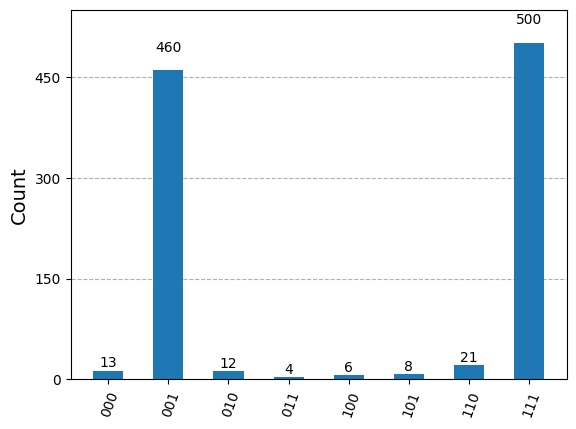

In [7]:
plot_histogram(answer)

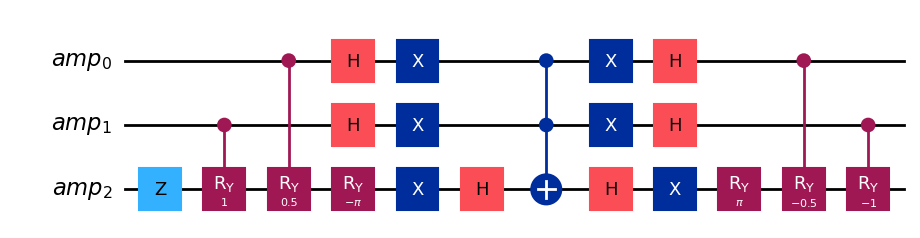

In [10]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram
import numpy as np

qr_amp = QuantumRegister(3, name='amp')
circuit = QuantumCircuit(qr_amp)

def ccry(circuit, theta, c1, c2, t):
    sub_q = QuantumRegister(3)
    sub_circ = QuantumCircuit(sub_q, name='$C^2R_Y$\n('+str(theta)[:5]+')')
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(-theta / 2, 2)
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(theta / 2, 2)
    sub_inst = sub_circ.to_instruction()
    circuit.append(sub_inst, [c1, c2, t])

# 振幅増幅
circuit.z(2)

circuit.cry(1, 1, 2)
circuit.cry(1 / 2, 0, 2)
circuit.ry(-np.pi, 2)
circuit.h([0, 1])

circuit.x([0, 1, 2])
circuit.h(2)
circuit.ccx(0, 1, 2)
circuit.h(2)
circuit.x([2, 1, 0])

circuit.h([0, 1])
circuit.ry(np.pi, 2)
circuit.cry(-1 / 2, 0, 2)
circuit.cry(-1, 1, 2)

# 回路図を描画
circuit.draw(output='mpl', fold=50)
